<a href="https://colab.research.google.com/github/jpireshe/AI-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sign Language Recognition App with Python - John Henares

This will be a project focused on recognizing sign language from videos input into it.

# Imports (Please read down below!)

In [204]:
import sys
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)
import json
import collections
import pickle
import pandas as pd
from itertools import zip_longest
import matplotlib.pyplot as plt

import sklearn
from sklearn import *
import tensorflow as tf

try:
  import mediapipe as mp
  from mediapipe.tasks import python
  from mediapipe.tasks.python import vision
  from mediapipe import solutions
  from mediapipe.framework.formats import landmark_pb2
except ImportError:
  !pip install -q mediapipe==0.10.0
  import mediapipe as mp
  from mediapipe.tasks import python
  from mediapipe.tasks.python import vision
  from mediapipe import solutions
  from mediapipe.framework.formats import landmark_pb2

if not os.path.exists("hand_landmarker.task"):
    !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

if not os.path.exists("image.jpg"):
    !wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
import torch.nn.functional as F

########################################################
############### IMPORTANT ##############################
########################################################

################################################################################
# Whoever runs this on their google drive will need to adjust their path variable.
# It should go to the project folder, where this file (project.ipynb) is located.
MY_PATH = 'drive/MyDrive/6th semester/ai/jpireshe-CSE30124-Fall2023-submissions/project/'
################################################################################

## GLOBALS - do not mess up with the rest here
JSON_PATH = MY_PATH + 'WLASL/start_kit/WLASL_v0.3.json'
## if you do not have access to the WLASL folder, just don't run the JSON traversal code
## (loading docs and going through json) and go straight to compiling splits into word_dict

MIN_VIDEOS = 8
MAX_DICT_SIZE = 35

DICT_PATH = MY_PATH + 'word_dict_'
EXTENSION_PATH = '1.pkl'

SKIPPED_PATH = MY_PATH + 'skipped_words.pkl'
WORD_SET_PATH = MY_PATH + 'word_set.pkl'

MIN_FRAMES = 18 # 0.74 second of video showing hand data

Mounted at /content/drive


# Getting hand landmarks

### Function that returns hand landmarks based on hand center on an image.

In [205]:
def get_hand_landmarks(frame, timestamp_ms, landmarker):
  # detect
  frame_data = np.array(frame, dtype=np.uint8)
  mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_data)
  detector_result = landmarker.detect_for_video(mp_image, int(timestamp_ms))

  # get data from detection
  handedness_list = detector_result.handedness
  world_landmarks_list = detector_result.hand_world_landmarks

  # no hand detected
  if not handedness_list: return None

  ret = {}

  # loop through detected hands
  for i in range(len(world_landmarks_list)):
    r = []
    hand_landmarks = world_landmarks_list[i]

    handedness = handedness_list[i][0].category_name

    # process hand landmark
    for l in hand_landmarks:
      r.append((l.x, l.y, l.z))

    # print() --> debug

    ret[handedness.lower()] = r

  return ret

### Wrapped for a whole video:

In [206]:
def get_video_hands(url, bbox=None, start_frame=0, end_frame=-1):
  BaseOptions = mp.tasks.BaseOptions
  HandLandmarker = mp.tasks.vision.HandLandmarker
  HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
  VisionRunningMode = mp.tasks.vision.RunningMode

  # create a hand landmarker instance with the video mode
  options = HandLandmarkerOptions(
      base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
      running_mode=VisionRunningMode.VIDEO)

  landmarker = HandLandmarker.create_from_options(options)
  cap = cv2.VideoCapture(url)

  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  if end_frame == -1:
    end_frame = total_frames

  hands = {'left': [], 'right': []}
  while cap.isOpened():
      # read a frame
      ret, frame = cap.read()
      if not ret: break

      # get frame num
      current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

      if start_frame <= current_frame <= end_frame:
        # crop
        if bbox:
          xmin, ymin, xmax, ymax = bbox
          frame = frame[ymin:ymax, xmin:xmax]

        # get timestamp
        timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)

        landmarks = get_hand_landmarks(frame, timestamp, landmarker)

        # no hand detected
        if not landmarks: continue

        if 'left' in landmarks: hands['left'].append(landmarks['left'])
        if 'right' in landmarks: hands['right'].append(landmarks['right'])

  cap.release()

  return hands

# JSON traversal and dictionary loading

### Loading Docs

In [207]:
# loading json
with open(JSON_PATH, 'r') as f:
  data = json.load(f)

# words to skip processing
skip_set = set()
try:
  with open(SKIPPED_PATH, 'rb') as f:
    skip_set = pickle.load(f)

except FileNotFoundError:
  with open(SKIPPED_PATH, 'wb') as f:
    pickle.dump(skip_set, f)

# words to know we already processes
word_set = set()
try:
  with open(WORD_SET_PATH, 'rb') as f:
    word_set = pickle.load(f)

except FileNotFoundError:
  with open(WORD_SET_PATH, 'wb') as f:
    pickle.dump(word_set, f)

# loading the dictionary of hand signs
EXTENSION_PATH = str(1 + len(word_set) // MAX_DICT_SIZE) + "." + EXTENSION_PATH.split(".")[1]
print('ext:', EXTENSION_PATH)
EXT_N = int(EXTENSION_PATH.split(".")[0])
print(EXT_N)

word_dict = collections.defaultdict(list)
try:
  with open(DICT_PATH + EXTENSION_PATH, 'rb') as f:
    word_dict = pickle.load(f)

except FileNotFoundError:
  with open(DICT_PATH + EXTENSION_PATH, 'wb') as f:
    pickle.dump(word_dict, f)

print(f"{len(word_set)} words in beginning, {len(skip_set)} skipped")


ext: 6.pkl
6
194 words in beginning, 1806 skipped


### Going through WLASL JSON and analyzing each video

In [208]:
# data = array of dictionaries with gloss (str) & instances (arr of dicts)
for info in data:
  gloss = info['gloss']

  if gloss in word_set or gloss in skip_set: continue
  print("New gloss:", gloss)

  # this will avoid the dataset from being too big
  ct = 0
  for instance in info['instances']:
    video_id = instance['video_id']
    path = f'/content/drive/MyDrive/6th semester/ai/WLASL/start_kit/videos/{video_id}.mp4'
    if os.path.exists(path):
      ct += 1

  if ct < MIN_VIDEOS:
    print("Skipped gloss", gloss)
    skip_set.add(gloss)

    with open(SKIPPED_PATH, 'wb') as f:
      pickle.dump(skip_set, f)

    continue

  print(f"There are {ct} videos")

  # go through instances for gloss
  ct = 0
  for instance in info['instances']:
    video_hands = {'left': [], 'right': []}

    # get info from json
    bbox = instance['bbox']
    fps = instance['fps']
    frame_end = instance['frame_end']
    frame_start = instance['frame_start']
    video_id = instance['video_id']
    path = f'/content/drive/MyDrive/6th semester/ai/WLASL/start_kit/videos/{video_id}.mp4'

    # check for video downloaded
    if os.path.exists(path):
      video_hands = get_video_hands(path, bbox, frame_start, frame_end)

    # put hands in dict
    if len(video_hands['left']) + len(video_hands['right']) >= MIN_FRAMES:
      word_dict[gloss].append(video_hands)
      ct += 1

  if ct < MIN_VIDEOS:
    print(f"Dropped gloss {gloss} for lack of data (only {ct} videos had enough data)")
    if gloss in word_dict: word_dict.pop(gloss)

    skip_set.add(gloss)

    with open(SKIPPED_PATH, 'wb') as f:
      pickle.dump(skip_set, f)

  else:
    print(f"Put {ct} videos in word_dict")

    word_set.add(gloss)

    with open(WORD_SET_PATH, 'wb') as f:
      pickle.dump(word_set, f)

  # save dict with new gloss
  with open(DICT_PATH + EXTENSION_PATH, 'wb') as f:
    pickle.dump(word_dict, f)

  print(f"Saved in {DICT_PATH + EXTENSION_PATH}")

  if len(word_dict) >= MAX_DICT_SIZE:
    EXTENSION_PATH = str(int(EXTENSION_PATH.split(".")[0]) + 1) + "." + EXTENSION_PATH.split(".")[1]
    word_dict = collections.defaultdict(list)
    print(f"New Path: {DICT_PATH + EXTENSION_PATH}")

print("Done!")
print(f"EXT_N: {EXT_N}")

Done!
EXT_N: 6


### Compiling the splits into word_dict

In [209]:
def get_word_dict():
  word_dict = {}
  for e in range(1, EXT_N + 1):
    wd = pickle.load(open(DICT_PATH + f'{e}.pkl', 'rb'))
    word_dict.update(wd)

  print(f"found {len(word_dict)} words with enough data\n")

  print("The words are:\n")
  i = 0
  for word in word_dict:
    print(word, end=", ")
    i += 1
    if i % 10 == 0: print()

  return word_dict

word_dict = get_word_dict()

found 194 words with enough data

The words are:

book, drink, computer, before, chair, go, clothes, who, candy, deaf, 
fine, help, no, thin, walk, year, yes, all, cool, finish, 
hot, like, mother, orange, thanksgiving, blue, dog, family, hearing, later, 
man, shirt, study, wrong, accident, apple, bird, change, color, corn, 
cow, dance, dark, doctor, enjoy, last, meet, pizza, play, time, 
work, basketball, brown, but, how, letter, medicine, visit, wait, water, 
yellow, cat, check, class, cry, different, door, green, hair, headache, 
laugh, learn, movie, rabbit, red, room, run, show, sick, teacher, 
with, yesterday, ball, bathroom, coffee, cold, far, friend, happy, home, 
leave, list, lose, name, problem, soon, sunday, test, arrive, balance, 
banana, beard, business, clock, country, crash, day, fat, feel, game, 
girl, hear, interest, join, more, most, past, please, practice, president, 
sandwich, sign, some, student, teach, theory, ugly, your, animal, argue, 
draw, friendly, glasses, ha

# Organize data into X and y

In [210]:
def get_X_y():
  X = []
  y_word = []

  put_words = 0

  for label, videos in word_dict.items():
      # will contain num_videos video_total variables
      total = []

      for video in videos:
          # contains all left hand signs for the video
          left_hand = video['left']

          # contains all right hand signs for the video
          right_hand = video['right']

          # will contain all hand signs flattened for the video
          video_total = []

          for left_frame, right_frame in zip_longest(left_hand, right_hand):
            if left_frame != None:
              video_total.append([x for x, _, _ in left_frame] + [y for _, y, _ in left_frame] + [z for z, _, _ in left_frame])

            if right_frame != None:
              video_total.append([x for x, _, _ in right_frame] + [y for _, y, _ in right_frame] + [z for z, _, _ in right_frame])

          # now, pick only videos that have enough frames
          if len(video_total) >= MIN_FRAMES: total.append(video_total)

      if len(total) < MIN_VIDEOS: continue
      put_words += 1

      for video_idx in range(len(total)):
        total[video_idx] = np.array(total[video_idx])

        # calculate the indices for the MIN_FRAMESth percentiles
        percentile_indices = np.percentile(np.arange(len(total[video_idx])), np.linspace(0, 100, MIN_FRAMES))
        percentile_indices = np.round(percentile_indices).astype(int)

        # get the elements
        percentile_elements = total[video_idx][percentile_indices]
        percentile_elements = [j for i in percentile_elements for j in i]

        total[video_idx] = percentile_elements

      for i in total:
        X.append(i)
        y_word.append(label)

  X = np.array(X)
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y_word)

  print(put_words, "words were put in X, totalizing", len(X), "videos, each with", len(X[0]), "patterns")

  return X, y, y_word, le

X, y, y_word, le = get_X_y()

194 words were put in X, totalizing 1873 videos, each with 1134 patterns


# Classifier examination

### Finding best classifier

In [211]:
def get_best_classifier():
  # divide dataset into test and train
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

  classifiers = [
    (sklearn.discriminant_analysis.LinearDiscriminantAnalysis(), 'Linear Classifier'),
    (sklearn.tree.DecisionTreeClassifier(random_state=30), 'Decision Tree'),
    (sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=42), 'Random Forest Classifier'),
    (sklearn.svm.LinearSVC(dual=False), 'Linear SVM'),
    (sklearn.svm.SVC(random_state=30, C=0.1), 'Non-linear SVM (c = 0.1)'),
    (sklearn.svm.SVC(random_state=30, C=1), 'Non-linear SVM (c = 1)'),
    (sklearn.svm.SVC(random_state=30, C=10), 'Non-linear SVM (c = 10)'),
    (sklearn.svm.SVC(random_state=30, C=20), 'Non-linear SVM (c = 20)'),
    (sklearn.svm.SVC(random_state=30, C=40), 'Non-linear SVM (c = 40)'),
    (sklearn.svm.SVC(random_state=30, C=60), 'Non-linear SVM (c = 60)'),
    (sklearn.svm.SVC(random_state=30, C=80), 'Non-linear SVM (c = 80)'),
    (sklearn.svm.SVC(random_state=30, C=100), 'Non-linear SVM (c = 100)'),
  ]

  best_clf, best_tag, best_accuracy = None, None, 0

  for clf, tag in classifiers:
    # get and fit classifier
    clf.fit(X_train, y_train)

    # predict on test data
    y_pred = clf.predict(X_test)

    # evaluate accuracy
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
      best_clf = clf
      best_accuracy = accuracy
      best_tag = tag
      print('New best!')

    print(f'Classifier: {tag} | Accuracy: {accuracy:.2f}\n')

  # KNN classifiers
  for k in range(1, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    ta = np.mean(model_selection.cross_val_score(knn, X_train, y_train, cv=4))

    knn.fit(X_train, y_train)
    tta = knn.score(X_test, y_test)

    y_pred = knn.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
      best_clf = knn
      best_accuract = accuracy
      best_tag = f'{k}-NN'

    print(f'Classifier: {k}-NN | Accuracy: {accuracy:.2f} | TTA: {tta:.2f}\n')

  print(f'Best Accuracy: {best_accuracy:.2f} on {best_tag}')
  return best_clf, best_accuracy

clf, accuracy = get_best_classifier()

New best!
Classifier: Linear Classifier | Accuracy: 0.12

Classifier: Decision Tree | Accuracy: 0.11

New best!
Classifier: Random Forest Classifier | Accuracy: 0.29

Classifier: Linear SVM | Accuracy: 0.28

Classifier: Non-linear SVM (c = 0.1) | Accuracy: 0.00

Classifier: Non-linear SVM (c = 1) | Accuracy: 0.22

New best!
Classifier: Non-linear SVM (c = 10) | Accuracy: 0.33

Classifier: Non-linear SVM (c = 20) | Accuracy: 0.32

Classifier: Non-linear SVM (c = 40) | Accuracy: 0.32

Classifier: Non-linear SVM (c = 60) | Accuracy: 0.32

Classifier: Non-linear SVM (c = 80) | Accuracy: 0.32

Classifier: Non-linear SVM (c = 100) | Accuracy: 0.32

Classifier: 1-NN | Accuracy: 0.28 | TTA: 0.28

Classifier: 2-NN | Accuracy: 0.27 | TTA: 0.27

Classifier: 3-NN | Accuracy: 0.25 | TTA: 0.25

Classifier: 4-NN | Accuracy: 0.26 | TTA: 0.26

Classifier: 5-NN | Accuracy: 0.25 | TTA: 0.25

Classifier: 6-NN | Accuracy: 0.26 | TTA: 0.26

Classifier: 7-NN | Accuracy: 0.26 | TTA: 0.26

Classifier: 8-NN | A

# Try It Yourself! (Classifier version)

In [213]:
## You can test with whatever video is in the WLASL/start_kit/videos folder
## given the video's word is in word_dict.

## I tested with the video with ID 69302 and got the right output - 'drink'

# get user video input
uploaded = files.upload()

for filename, video_data in uploaded.items():
  video = get_video_hands(filename)

  # contains all left hand signs for the video
  left_hand = video['left']

  # contains all right hand signs for the video
  right_hand = video['right']

  video_total = []

  for left_frame, right_frame in zip_longest(left_hand, right_hand):
    if left_frame != None:
      video_total.append([x for x, _, _ in left_frame] + [y for _, y, _ in left_frame] + [z for z, _, _ in left_frame])

    if right_frame != None:
      video_total.append([x for x, _, _ in right_frame] + [y for _, y, _ in right_frame] + [z for z, _, _ in right_frame])

  video_total = np.array(video_total)

  # calculate the indices for the MIN_FRAMESth percentiles
  percentile_indices = np.percentile(np.arange(len(video_total)), np.linspace(0, 100, MIN_FRAMES))
  percentile_indices = np.round(percentile_indices).astype(int)

  # get the elements
  percentile_elements = video_total[percentile_indices]
  percentile_elements = [j for i in percentile_elements for j in i]

  video_total = np.array(percentile_elements)

  # throw into classifier
  pred = clf.predict([video_total])
  pred_words = le.inverse_transform(pred)

  print(f'The predicted word for the video is: {pred_words[0]}')

  break

Saving 69302.mp4 to 69302 (3).mp4
The predicted word for the video is: drink


# Neural Net section

### Reorganizing data into nX and ny

In [220]:
MIN_FRAMES = 25 # 1 second of video showing hand data
# MIN_FRAMES = 10

nX = []
ny = []

put_words = 0
for label, videos in word_dict.items():
    # will contain num_videos video_total variables
    total = []

    for video in videos:
        # contains all left hand signs for the video
        left_hand = video['left']

        # contains all right hand signs for the video
        right_hand = video['right']

        # will contain all hand signs flattened for the video
        video_total = []

        for left_frame, right_frame in zip_longest(left_hand, right_hand):
          if left_frame != None:
            t = []
            for x, y, z in left_frame:
              t += [x, y, z]

            video_total.append(t)

          if right_frame != None:
            t = []
            for x, y, z in right_frame:
              t += [x, y, z]

            video_total.append(t)

        # now, pick only videos that have enough frames
        if len(video_total) >= MIN_FRAMES: total.append(video_total)

    for video_idx in range(len(total)):
      total[video_idx] = np.array(total[video_idx])

      # calculate the indices for the MIN_FRAMESth percentiles
      percentile_indices = np.percentile(np.arange(len(total[video_idx])), np.linspace(0, 100, MIN_FRAMES))
      percentile_indices = np.round(percentile_indices).astype(int)

      # get the elements
      percentile_elements = total[video_idx][percentile_indices]

      total[video_idx] = percentile_elements

    for i in total:
      nX.append(i)
      ny.append(label)

nX = torch.tensor(nX, dtype=torch.float32)
le = preprocessing.LabelEncoder()
ny = torch.tensor(le.fit_transform(ny), dtype=torch.float32)

### Neural network training and evaluation

In [221]:
dataset = TensorDataset(nX, ny)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class HandSignClassifier(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, num_classes):
        super(HandSignClassifier, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_channels * ((63 - kernel_size + 1) // 2), num_classes)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

input_channels = MIN_FRAMES
output_channels = len(word_dict)
print(f"Output channels: {output_channels}")
kernel_size = 3

model = HandSignClassifier(input_channels, output_channels, kernel_size, output_channels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x)

        # Compute loss
        loss = criterion(outputs, batch_y.long())
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted_classes = torch.max(outputs, 1)
        correct = (predicted_classes == batch_y).sum().item()
        total_correct += correct
        total_samples += batch_y.size(0)

    # Calculate accuracy for the epoch
    accuracy = total_correct / total_samples

    # Print epoch statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.2f}, Accuracy: {accuracy * 100:.2f}%')


# Test the model on your test set if available
model.eval()
with torch.no_grad():
    test_outputs = model(nX)

    # Use torch.max to get the predicted class indices
    _, test_predictions = torch.max(test_outputs, 1)

    test_accuracy = (test_predictions == ny).sum().item() / ny.size(0)
    print(f'Final Test Accuracy: {test_accuracy * 100:.2f}')

Output channels: 194
Epoch [1/30], Loss: 262.85, Accuracy: 1.03%
Epoch [2/30], Loss: 232.20, Accuracy: 5.77%
Epoch [3/30], Loss: 185.77, Accuracy: 18.85%
Epoch [4/30], Loss: 151.86, Accuracy: 28.78%
Epoch [5/30], Loss: 128.75, Accuracy: 37.44%
Epoch [6/30], Loss: 111.54, Accuracy: 43.91%
Epoch [7/30], Loss: 96.35, Accuracy: 51.22%
Epoch [8/30], Loss: 85.58, Accuracy: 54.62%
Epoch [9/30], Loss: 75.28, Accuracy: 60.13%
Epoch [10/30], Loss: 66.47, Accuracy: 64.17%
Epoch [11/30], Loss: 58.96, Accuracy: 67.63%
Epoch [12/30], Loss: 51.46, Accuracy: 72.63%
Epoch [13/30], Loss: 46.45, Accuracy: 74.04%
Epoch [14/30], Loss: 40.56, Accuracy: 78.46%
Epoch [15/30], Loss: 35.79, Accuracy: 81.47%
Epoch [16/30], Loss: 31.79, Accuracy: 83.01%
Epoch [17/30], Loss: 28.66, Accuracy: 85.71%
Epoch [18/30], Loss: 25.18, Accuracy: 87.24%
Epoch [19/30], Loss: 22.73, Accuracy: 89.04%
Epoch [20/30], Loss: 20.39, Accuracy: 90.77%
Epoch [21/30], Loss: 18.61, Accuracy: 91.67%
Epoch [22/30], Loss: 17.06, Accuracy: 9

# Try it yourself! (Neural Net version)

In [222]:
## You can test with whatever video is in the WLASL/start_kit/videos folder
## given the video's word is in word_dict.

## I tested with the video with ID 69302 and got the right output - 'drink'
## I also tested with the video with ID 69241 and got the right output - 'book'
## bear in mind that this can always change

# get user video input
uploaded = files.upload()

for filename, video_data in uploaded.items():
  video = get_video_hands(filename)

  # contains all left hand signs for the video
  left_hand = video['left']

  # contains all right hand signs for the video
  right_hand = video['right']

  video_total = []

  for left_frame, right_frame in zip_longest(left_hand, right_hand):
          if left_frame != None:
            t = []
            for x, y, z in left_frame:
              t += [x, y, z]

            video_total.append(t)

          if right_frame != None:
            t = []
            for x, y, z in right_frame:
              t += [x, y, z]

            video_total.append(t)

  video_total = np.array(video_total)

  # calculate the indices for the MIN_FRAMESth percentiles
  percentile_indices = np.percentile(np.arange(len(video_total)), np.linspace(0, 100, MIN_FRAMES))
  percentile_indices = np.round(percentile_indices).astype(int)

  # get the elements
  percentile_elements = video_total[percentile_indices]

  # create a new tensor with the correct data type
  video_total = torch.tensor([percentile_elements], dtype=torch.double)

  # throw into classifier
  model = model.double()
  model.eval()
  with torch.no_grad():
      model_output = model(video_total.double())  # explicitly set the data type here
      _, pred = torch.max(model_output, 1)

  pred_words = le.inverse_transform(pred)

  print(f'The predicted word for the video is: {pred_words[0]}')
  break

Saving 69241.mp4 to 69241 (39).mp4
The predicted word for the video is: book


# Extras

### **DRAWING ON IMAGE**
These  cell contain a function that draws hand landmarks on an image

In [ ]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    #print(handedness)
    #print(hand_landmarks_list)
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

Sample usage:

[Category(index=1, score=0.9357715249061584, display_name='Right', category_name='Right')]
[[NormalizedLandmark(x=0.39291912317276, y=0.7066095471382141, z=-3.293027077688748e-07, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.34312063455581665, y=0.7504479885101318, z=-0.019821790978312492, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.2708950638771057, y=0.7737331986427307, z=-0.027366425842046738, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.20807738602161407, y=0.779670238494873, z=-0.03694787248969078, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.15704940259456635, y=0.7829774022102356, z=-0.04580849036574364, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.2020859718322754, y=0.7279683947563171, z=0.004851780831813812, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.13295286893844604, y=0.743130087852478, z=-0.01850949414074421, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.09457877278327942, y=0.7587484121322632, z=-0.04270356

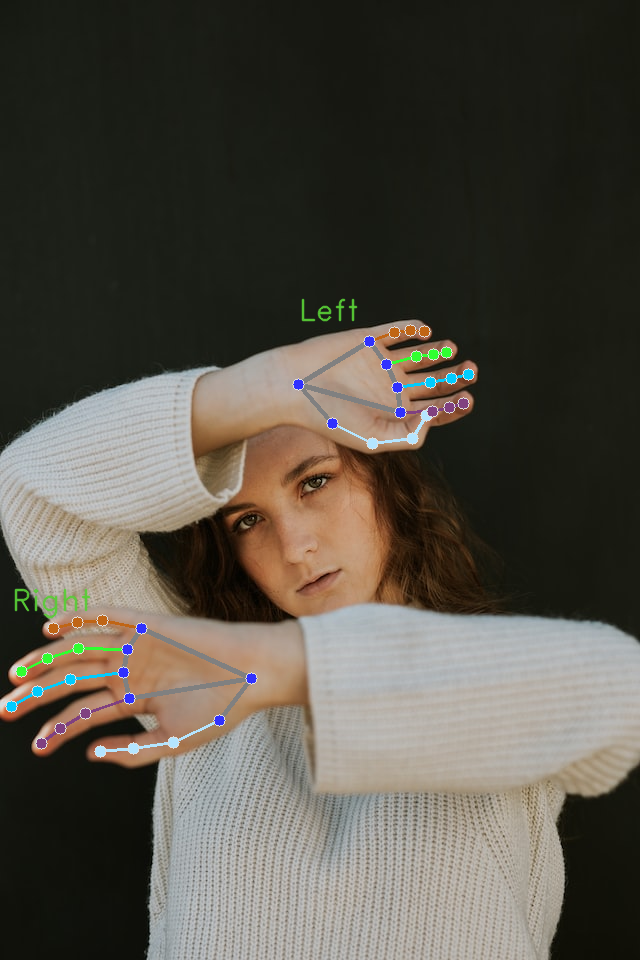

In [ ]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)


# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



# Lowering the number of Hand Signs

### OPTIONAL: if you desire, you can lower the number of glosses to have better model performance.

In [135]:
# you can put whatever number you want here
NUM_GLOSSES = 50

# only stay with glosses that have most data
print(f'There are {len(word_dict)} words in word_dict\n')

keys_to_stay = [i[1] for i in sorted([(len(word_dict[key]), key) for key in list(word_dict.keys())], reverse=True)[:NUM_GLOSSES]]

for key in list(word_dict.keys()):
  if key not in keys_to_stay:
    del word_dict[key]

print(f'Now there are {len(word_dict)} words in word_dict')
print("The words are:")
i = 0
for word in word_dict:
  print(word, end=", ")
  i += 1
  if i % 10 == 0: print()

There are 194 words in word_dict

Now there are 50 words in word_dict
The words are:
book, drink, computer, before, chair, go, clothes, who, candy, deaf, 
fine, no, yes, all, cool, like, mother, thanksgiving, family, hearing, 
later, shirt, study, accident, color, corn, cow, meet, play, time, 
brown, visit, wait, water, check, different, movie, rabbit, sick, yesterday, 
ball, sunday, interest, glasses, perspective, sad, temperature, slow, toast, pass, 
